<a href="https://colab.research.google.com/github/pachterlab/CP_2023/blob/main/notebooks/uteroMixingAnalysis_Fig3a/uteroAnalysis_withNoPCAPreprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysis with L1 norm and without PCA-preprocessing of the data (prior to reduction to 2D)

In [ ]:
#Read in files from NCBI GEO
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.MetaData.105.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv.gz

!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.MetaData.85.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.normalized.assay85.csv.gz

#integrated.scaled.assay105

In [ ]:
!gunzip *.gz

In [ ]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 145 (delta 78), reused 95 (delta 38), pack-reused 0
Receiving objects: 100% (145/145), 412.94 KiB | 10.32 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
%cd ./densvis/densne/

/home/tchari/densvis/densne


In [ ]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

In [ ]:
%cd ../../

/home/tchari


In [ ]:
!git clone https://github.com/pachterlab/CP_2023.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (291/291), done.
remote: Total 335 (delta 167), reused 87 (delta 20), pack-reused 0
Receiving objects: 100% (335/335), 83.12 MiB | 17.07 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [ ]:
%cd ./CP_2023/scripts

/home/tchari/CP_2022/scripts


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy

     |████████████████████████████████| 96 kB 2.5 MB/s 
     |████████████████████████████████| 10.2 MB 5.2 MB/s 
     |████████████████████████████████| 69 kB 5.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


## **Install Packages**

In [ ]:
import statistics
import anndata
import pandas as pd
import numpy as np

#from Picasso import Picasso
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
#import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
#sns.set_style('white')


## **Analysis of E10.5 Data**

In [ ]:
# General parameters
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../..'

n_latent = 50
pcs = 15
pcs2 = 15

In [ ]:
def readLgMat(fname, data_path='/content'):

  col_names = pd.read_csv(data_path+fname, nrows=0).columns
  types_dict = {'Unnamed: 0': str}
  types_dict.update({col: np.float16 for col in col_names if col not in types_dict})

  chunk = pd.read_csv(data_path+fname,chunksize=1000,index_col=0,dtype=types_dict)
  counts = pd.concat(chunk)

  return counts

Read in Seurat-Integrated, 'Variance-Stabilized' and Scaled counts

In [ ]:
# fname = '/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv' #'/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv'

counts = readLgMat('/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv',data_path)
counts.head()

AAACCCAAGCCTCACG-1  AAACCCAAGCTCGACC-1  AAACCCAAGTTAACAG-1  \
Hba-a1            -0.366699           -0.303711           -0.294678   
Hbb-bh1           -0.391846           -0.164429           -0.295654   
Hba-x              0.409912           -0.145752           -0.494385   
Gfod2             -0.947266           -0.459229           -0.254395   
Mt1               -0.296143           -0.667480           -0.426270   

         AAACCCACACCATATG-1  AAACCCAGTCACGCTG-1  AAACCCAGTGCGTTTA-1  \
Hba-a1             2.830078            3.193359           -0.350342   
Hbb-bh1            2.917969            3.232422           -0.368408   
Hba-x              2.945312            3.166016           -0.245972   
Gfod2             -0.182373            0.062988            0.299316   
Mt1                1.979492            1.252930           -0.436035   

         AAACCCAGTGGCTCTG-1  AAACCCATCCCATAGA-1  AAACGAAAGAAGCTCG-1  \
Hba-a1             2.978516           -0.426758           -0.448486   
Hbb-bh1            2.914062           -0.369385           -0.449463   
Hba-x              2.966797           -0.169556           -0.375977   
Gfod2              0.217407           -0.358154           -0.587402   
Mt1                2.855469            0.118347           -0.274170   

         AAACGAAAGACTAAGT-1  ...  TTTGGAGTCCCGAGTG-12  TTTGGTTAGTCTAACC-12  \
Hba-a1            -0.161011  ...            -0.313965            -0.265381   
Hbb-bh1           -0.322998  ...            -0.771973            -0.245239   
Hba-x             -0.462646  ...            -0.627441            -0.453369   
Gfod2             -0.140625  ...             0.168213            -0.163818   
Mt1                1.331055  ...            -0.440186            -0.308594   

         TTTGGTTCACAAAGCG-12  TTTGGTTGTATGAGGC-12  TTTGGTTTCGTGGCTG-12  \
Hba-a1             -0.435791            -0.354004            -0.579102   
Hbb-bh1            -0.029694            -0.744141            -0.196533   
Hba-x              -0.015388            -0.108826             0.317627   
Gfod2               3.056641            -0.401123             1.704102   
Mt1                -0.475098            -0.369385            -0.430664   

         TTTGTTGAGCAGCGAT-12  TTTGTTGCAGTCCGTG-12  TTTGTTGCAGTTCACA-12  \
Hba-a1             -0.314209             2.933594            -0.290771   
Hbb-bh1            -0.491455             2.970703             0.188110   
Hba-x              -0.010666             2.923828            -0.601562   
Gfod2              -0.355225            -0.213501            -0.847656   
Mt1                -0.371094             2.318359            -0.437744   

         TTTGTTGGTCGTGTTA-12  TTTGTTGTCCAACCAA-12  
Hba-a1             -0.413330            -0.441895  
Hbb-bh1            -0.280029            -0.370117  
Hba-x              -0.346924             0.152100  
Gfod2               0.135742             1.581055  
Mt1                -0.575684            -0.642090  

[5 rows x 56528 columns]

In [ ]:
cellMeta = pd.read_csv(data_path+'/GSE149372_GSM5068636-GSM5068641_scRNA.MetaData.105.csv')
print(cellMeta.head())

           Unnamed: 0 orig.ident  nCount_RNA  nFeature_RNA  samples Utero  \
0  AAACCCAAGCCTCACG-1      p10.5        4451          2028        1  ExUt   
1  AAACCCAAGCTCGACC-1      p10.5        8096          2793        1  ExUt   
2  AAACCCAAGTTAACAG-1      p10.5        6994          2760        1  ExUt   
3  AAACCCACACCATATG-1      p10.5       19467          3424        1  ExUt   
4  AAACCCAGTCACGCTG-1      p10.5        8205          1481        1  ExUt   

   percent.mt  integrated_snn_res.0.3  
0    5.526848                       7  
1    4.088439                       5  
2    3.345725                       5  
3    4.166025                       3  
4    1.962218                       3  


In [ ]:
#Center and scale data
count_mat = counts.values.T

In [ ]:
adata = anndata.AnnData(X = count_mat)
adata.obs_names = list(counts.columns)
adata.var_names = list(counts.index)
adata.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata.obs['Cluster'] = pd.Categorical(cellMeta['integrated_snn_res.0.3'])
adata

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'

In [ ]:
#In paper, use top 2000 HVGs and 15 PCs
adata.obsm['log'] = adata.X #Data is already scaled so 'log' here is not just log-normalized

sc.pp.scale(adata, max_value=10) #Already scaled
adata

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'
    var: 'mean', 'std'
    obsm: 'log'

In [ ]:
count_mat = adata.obsm['log']
scaled_mat = adata.X

In [ ]:
#Set colors for cell clusters
colors = np.random.rand(len(adata.obs['Cluster']),3)

In [ ]:

labs = np.array([list(adata.obs['Cluster']),list(adata.obs['Utero'])])


Original log-normalized counts (post-Seurat integration)



In [ ]:
#GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv, Only Log-normalized data, not integrated
counts2_orig = readLgMat('/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv',data_path)
counts2 = counts2_orig.loc[list(adata.var_names)]
counts2.shape

(2000, 56528)

In [ ]:
counts2_orig.shape

(21164, 56528)

In [ ]:
#Center and scale log-normalized data
count_mat_orig = counts2.values.T

In [ ]:
adata2 = anndata.AnnData(X = count_mat_orig)
adata2.obs_names = list(counts2.columns)
adata2.var_names = list(counts2.index)
adata2.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata2.obs['Cluster'] = pd.Categorical(cellMeta['integrated_snn_res.0.3'])
adata2

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'

In [ ]:
adata2.obsm['log'] = adata2.X #Data matrix is log-normalized

adata2.raw = adata2.copy()

sc.pp.scale(adata2, max_value=10)
adata2

AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'
    var: 'mean', 'std'
    obsm: 'log'

In [ ]:
count_mat_orig = adata2.obsm['log']
scaled_mat_orig = adata2.X

Make separate matrices for ex and in utero counts

In [ ]:
counts2_orig.head()

AAACCCAAGCCTCACG-1  AAACCCAAGCTCGACC-1  AAACCCAAGTTAACAG-1  \
Xkr4                   0.0            0.000000            0.000000   
Rp1                    0.0            0.000000            0.000000   
Sox17                  0.0            0.000000            0.000000   
Mrpl15                 0.0            1.244141            0.887695   
Lypla1                 0.0            0.000000            0.000000   

        AAACCCACACCATATG-1  AAACCCAGTCACGCTG-1  AAACCCAGTGCGTTTA-1  \
Xkr4              0.000000            0.000000                 0.0   
Rp1               0.000000            0.000000                 0.0   
Sox17             0.000000            0.000000                 0.0   
Mrpl15            0.706543            0.796875                 0.0   
Lypla1            0.414551            0.000000                 0.0   

        AAACCCAGTGGCTCTG-1  AAACCCATCCCATAGA-1  AAACGAAAGAAGCTCG-1  \
Xkr4              0.000000            0.000000            0.000000   
Rp1               0.000000            0.000000            0.000000   
Sox17             0.000000            0.000000            0.000000   
Mrpl15            0.791504            0.946777            1.662109   
Lypla1            0.000000            0.581543            1.142578   

        AAACGAAAGACTAAGT-1  ...  TTTGGAGTCCCGAGTG-12  TTTGGTTAGTCTAACC-12  \
Xkr4               0.00000  ...             0.000000             0.000000   
Rp1                0.00000  ...             0.000000             0.000000   
Sox17              0.00000  ...             0.000000             0.000000   
Mrpl15             0.00000  ...             0.000000             1.047852   
Lypla1             1.78418  ...             1.663086             0.000000   

        TTTGGTTCACAAAGCG-12  TTTGGTTGTATGAGGC-12  TTTGGTTTCGTGGCTG-12  \
Xkr4                    0.0             0.000000                  0.0   
Rp1                     0.0             0.000000                  0.0   
Sox17                   0.0             0.000000                  0.0   
Mrpl15                  0.0             1.452148                  0.0   
Lypla1                  0.0             0.000000                  0.0   

        TTTGTTGAGCAGCGAT-12  TTTGTTGCAGTCCGTG-12  TTTGTTGCAGTTCACA-12  \
Xkr4               0.000000             0.000000                  0.0   
Rp1                0.000000             0.000000                  0.0   
Sox17              0.000000             0.000000                  0.0   
Mrpl15             1.651367             1.004883                  0.0   
Lypla1             0.000000             0.000000                  0.0   

        TTTGTTGGTCGTGTTA-12  TTTGTTGTCCAACCAA-12  
Xkr4                    0.0                  0.0  
Rp1                     0.0                  0.0  
Sox17                   0.0                  0.0  
Mrpl15                  0.0                  0.0  
Lypla1                  0.0                  0.0  

[5 rows x 56528 columns]

In [ ]:
# countEx_orig = counts2_orig.loc[:,list(adata2[adata2.obs['Utero'] == "ExUt"].obs_names) ]#list(adata2[adata2.obs['Utero'].isin(["ExUt"])].obs_names)]
# countEx_orig.shape

(21164, 34982)

In [ ]:
# countIn_orig = counts2_orig.loc[:,list(adata2[adata2.obs['Utero'] == "InUt"].obs_names) ]#list(adata2[adata2.obs['Utero'].isin(["ExUt"])].obs_names)]
# countIn_orig.shape

(21164, 21546)

In [ ]:
# ex_orig_names = adata2[adata2.obs['Utero'] == "ExUt"].obs['Cluster']
# in_orig_names = adata2[adata2.obs['Utero'] == "InUt"].obs['Cluster']

### **Run UMAP/2D Embeddings**
Following procedure in original study

In [ ]:
reducer = umap.UMAP(n_components = ndims, random_state = state)
#densUMAP = umap.UMAP(n_components = ndims, random_state = state,densmap=True)
tsne = TSNE(n_components = ndims, random_state = state)

In [ ]:
#PCA
tsvd = TruncatedSVD(n_components=pcs)
x_pca = tsvd.fit_transform(scaled_mat)



pcaUMAP = reducer.fit_transform(x_pca)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
#PCA on log-normalized data
tsvd = TruncatedSVD(n_components=pcs)
x_pca_log = tsvd.fit_transform(scaled_mat_orig)


pcalogUMAP = reducer.fit_transform(x_pca_log)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
#---------- 2d NOT PCA-preprocessed embeddings ---------------

tsvd = TruncatedSVD(n_components=2)
pca2_orig = tsvd.fit_transform(scaled_mat_orig)
umap2_orig = reducer.fit_transform(count_mat_orig)

tsvd = TruncatedSVD(n_components=2)
pca2_scale = tsvd.fit_transform(scaled_mat)
umap2_scale = reducer.fit_transform(count_mat)



Embedding Plots

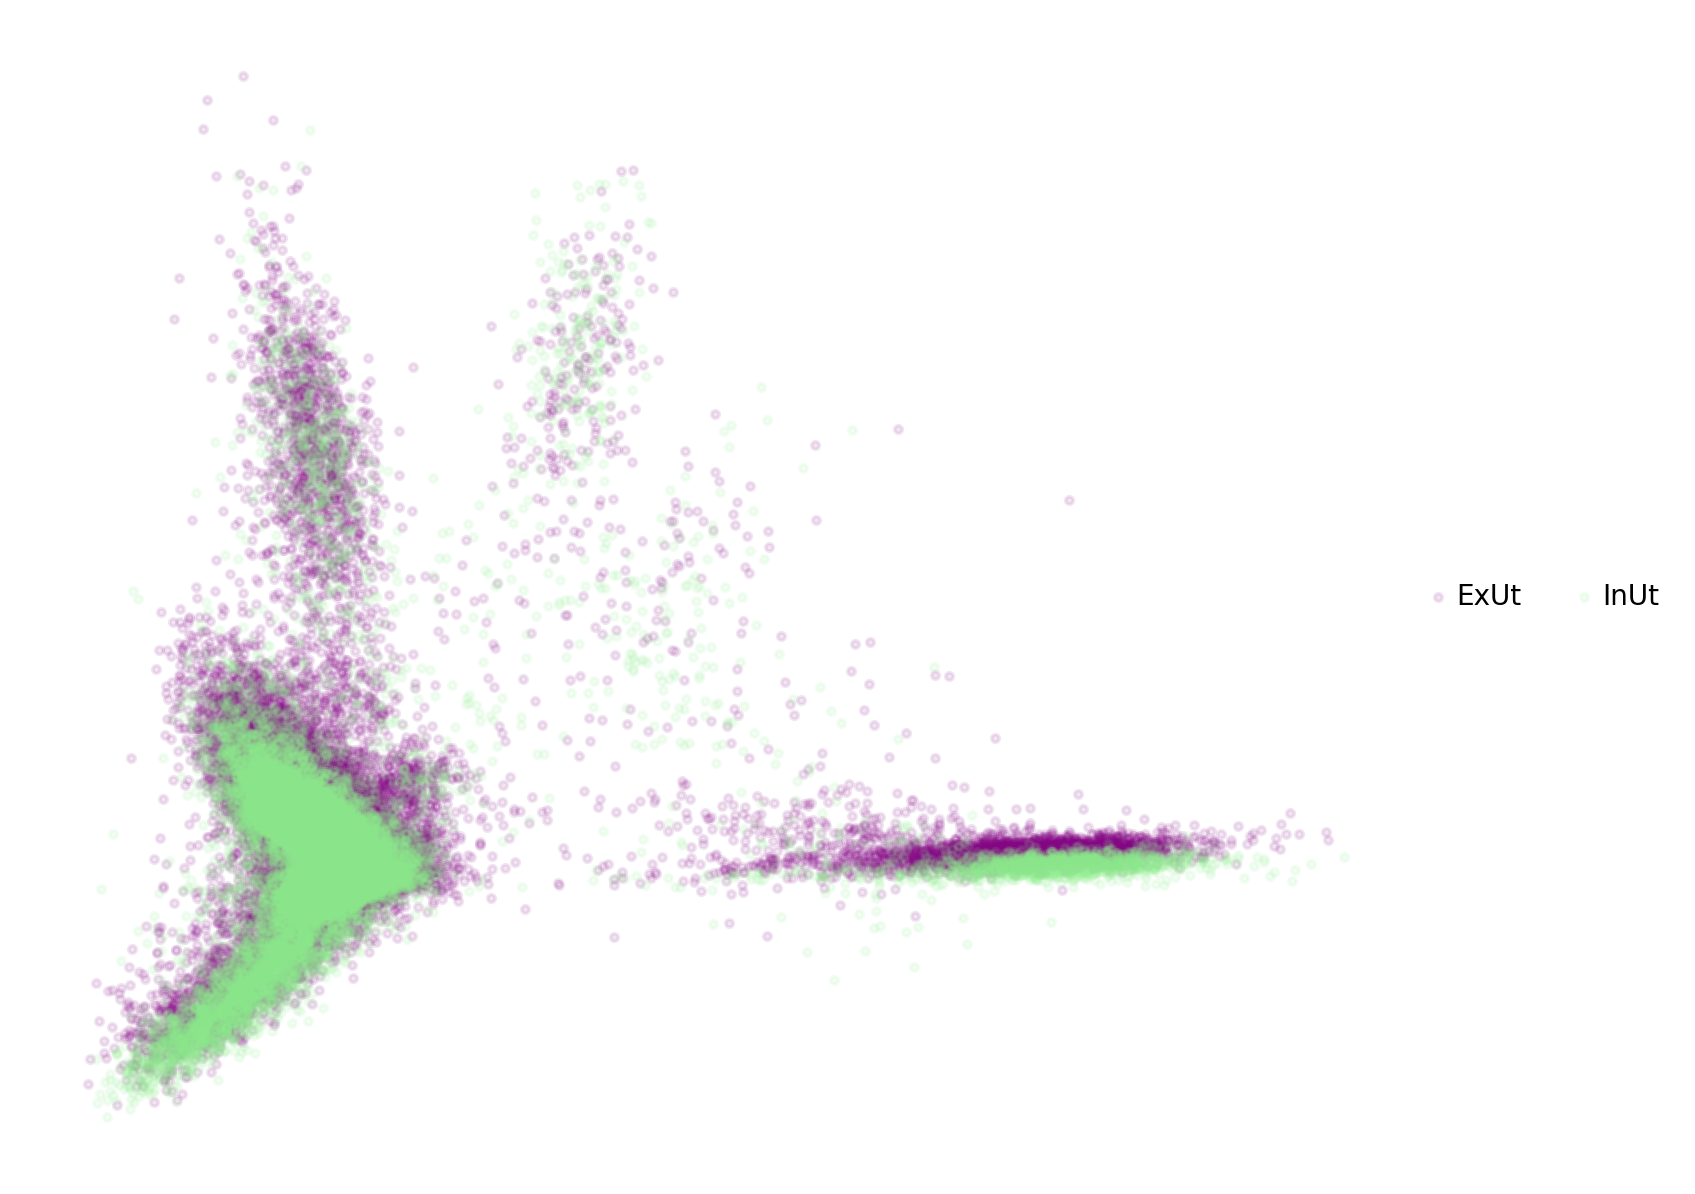

In [ ]:
vis.obj_plot_embed(pca2_orig, labs[1], fname = '2DNCA.pdf',colors=['purple','lightgreen'],alpha = 0.1)

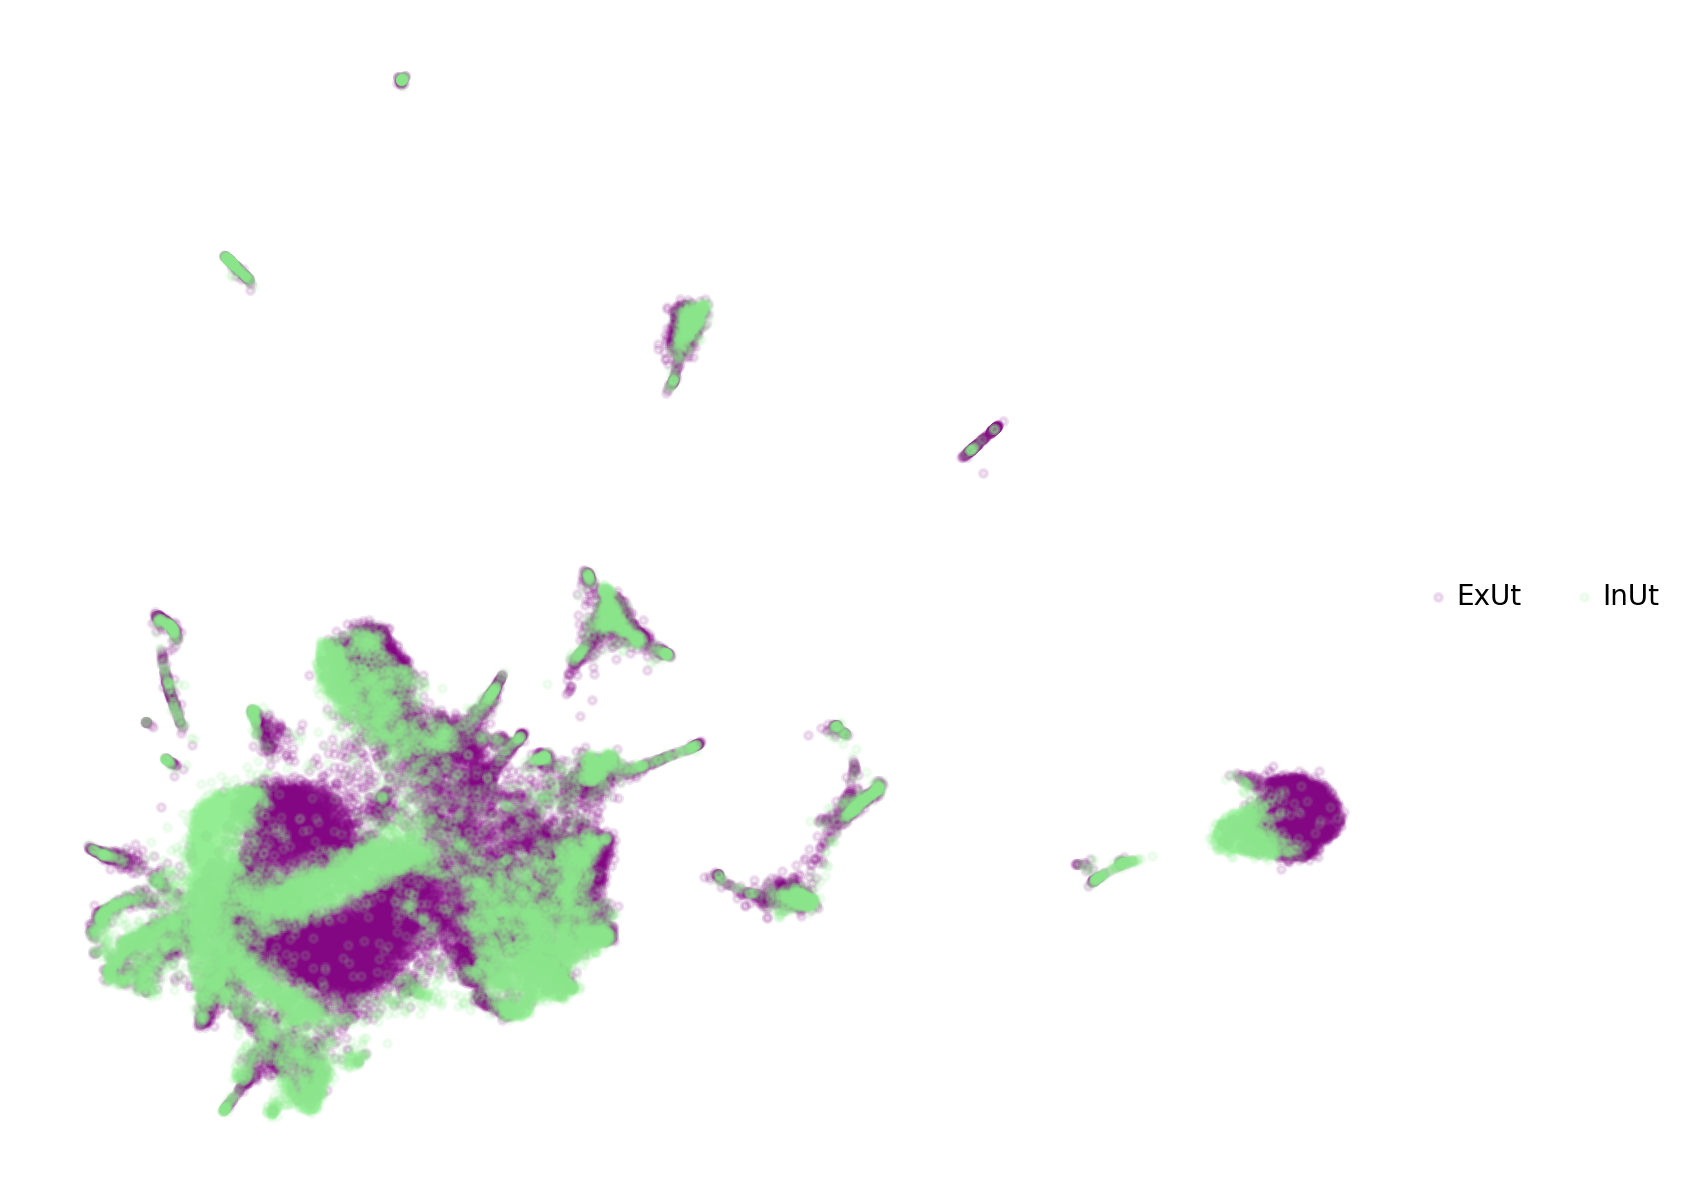

In [ ]:
vis.obj_plot_embed(umap2_orig, labs[1], fname = '2DNCA.pdf',colors=['purple','lightgreen'],alpha = 0.1)

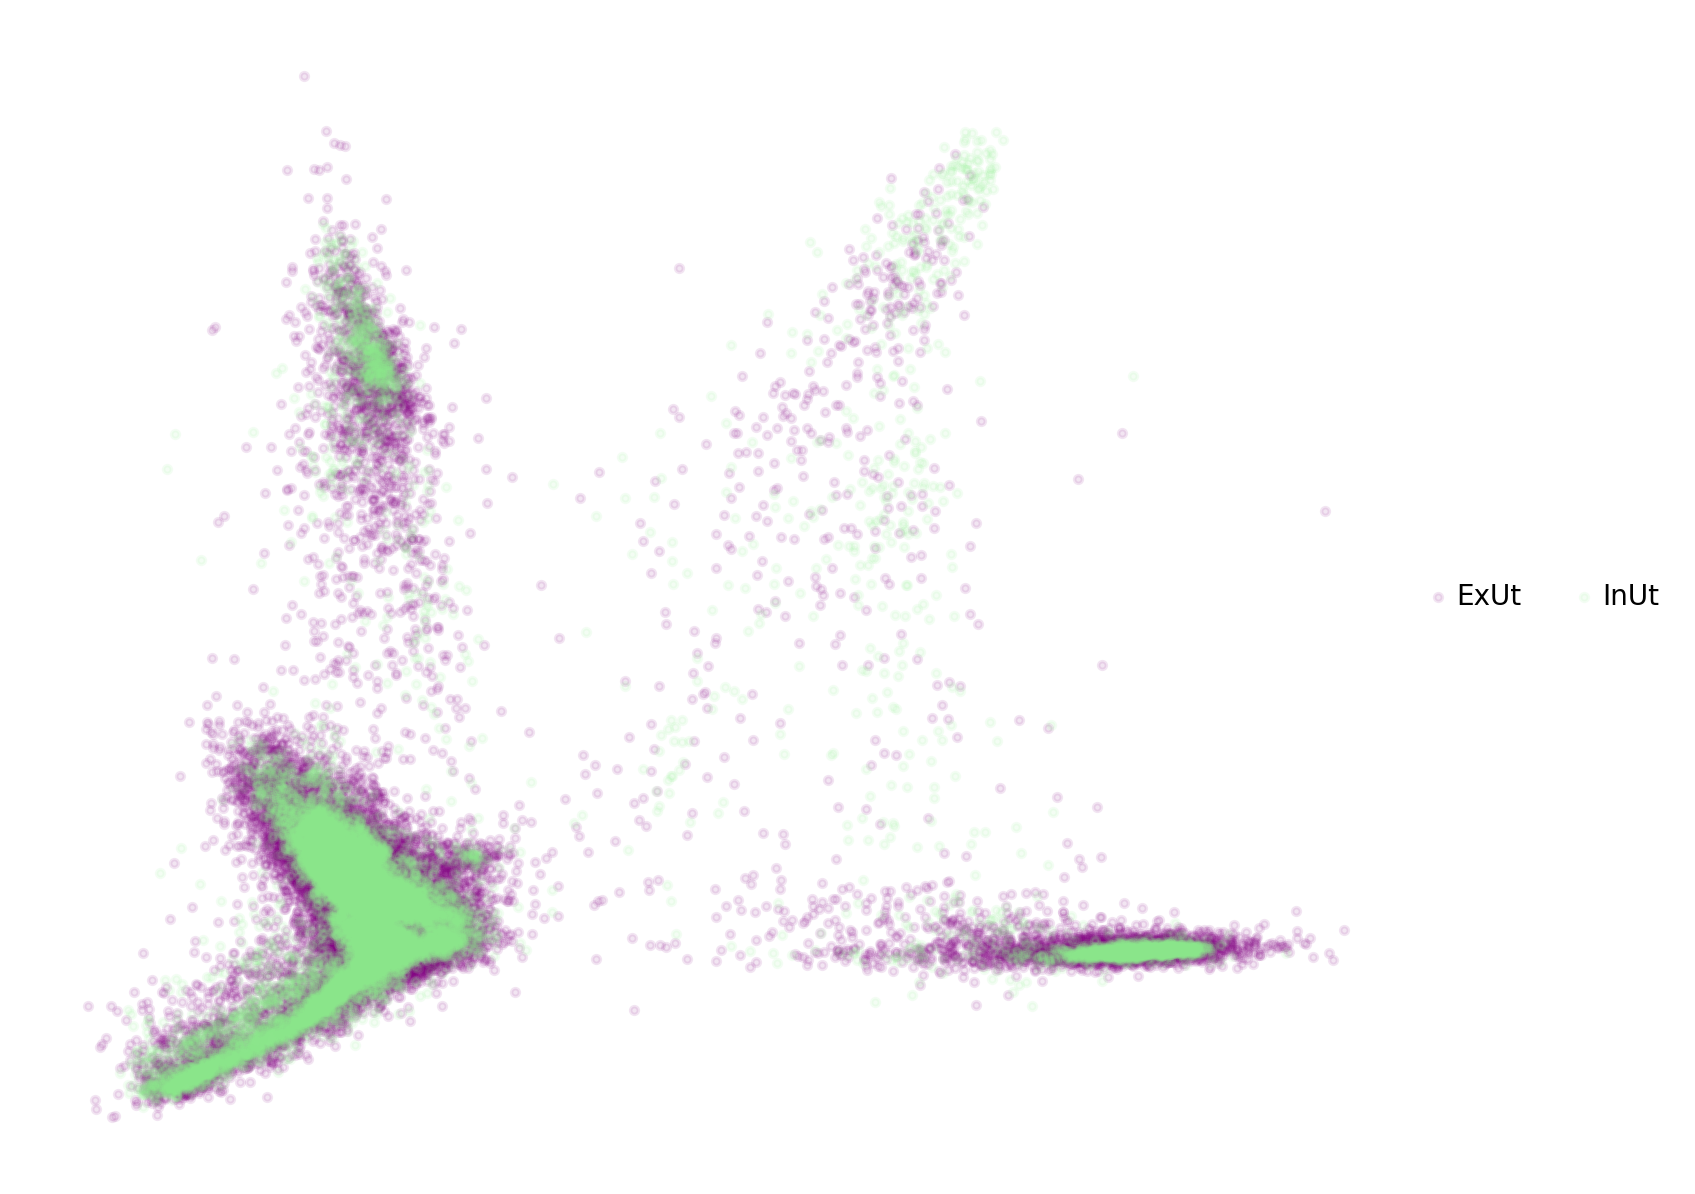

In [ ]:
vis.obj_plot_embed(pca2_scale, labs[1], fname = '2DNCA.pdf',colors=['purple','lightgreen'],alpha = 0.1)

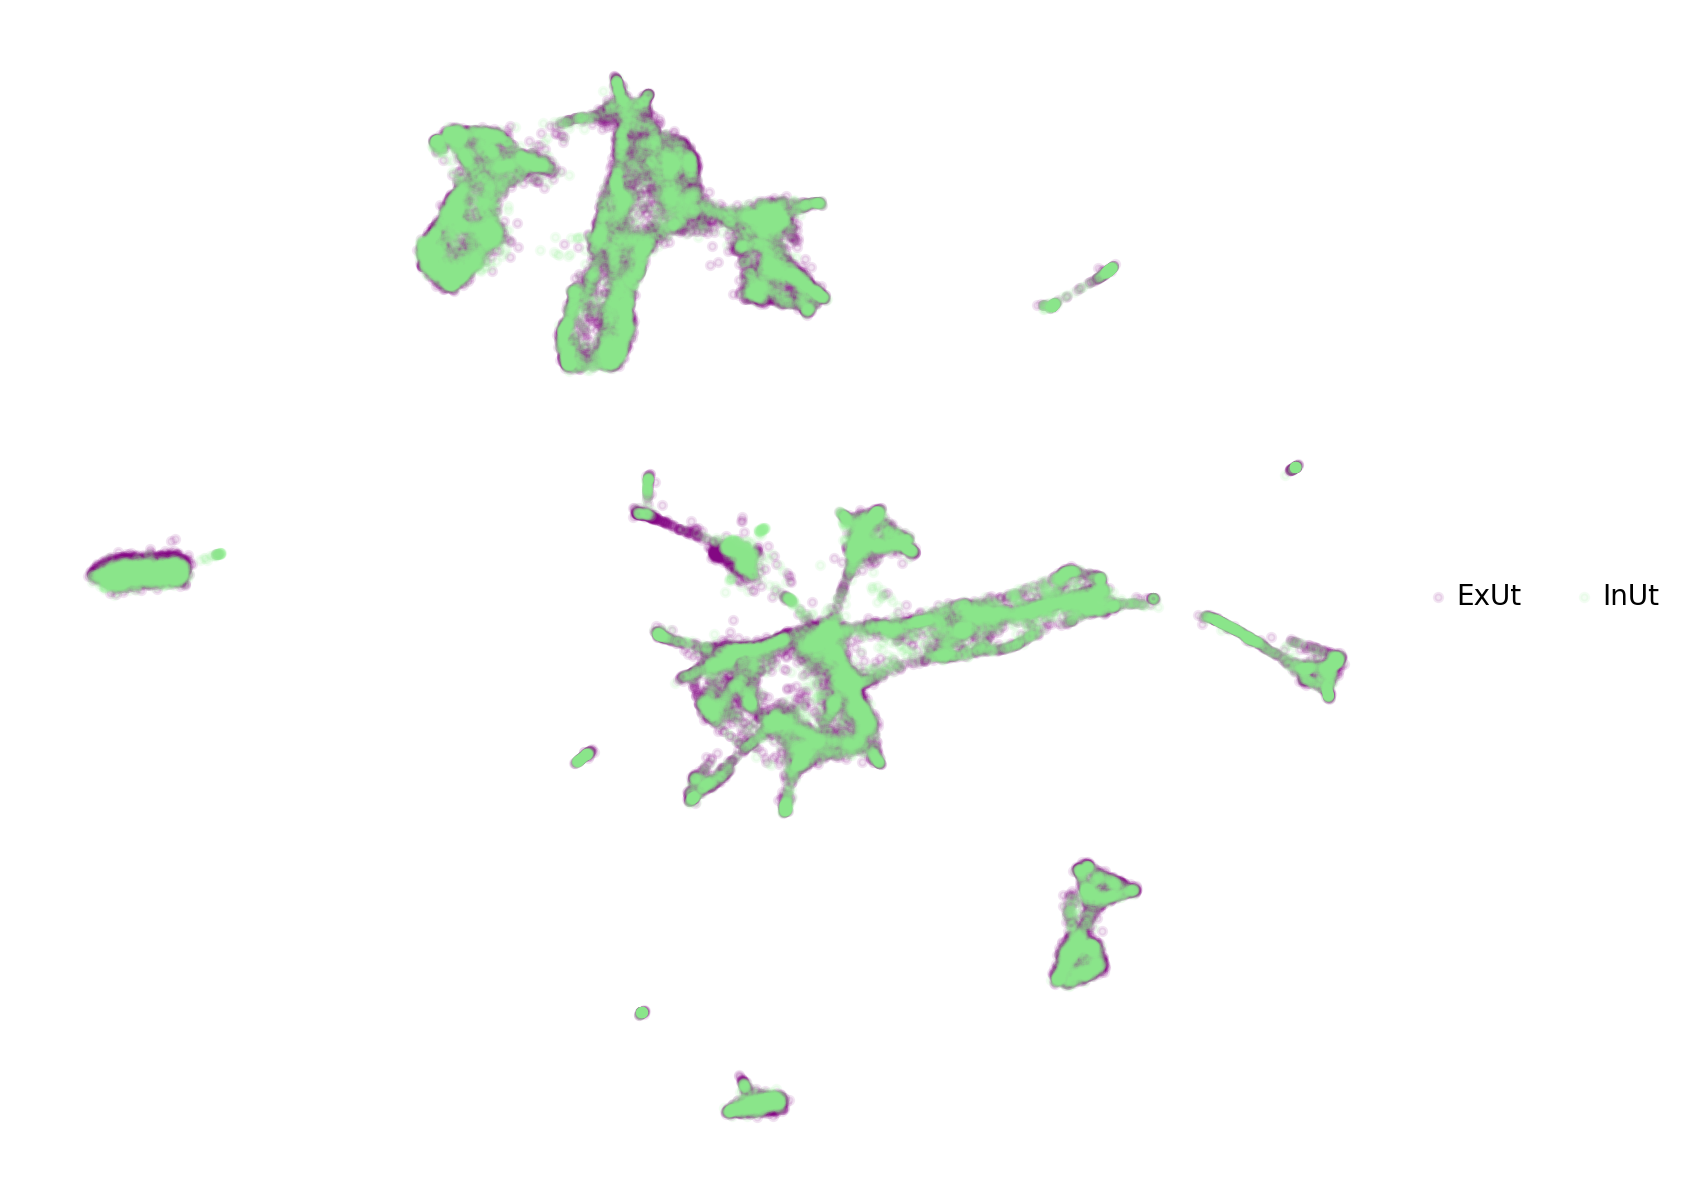

In [ ]:
vis.obj_plot_embed(umap2_scale, labs[1], fname = '2DNCA.pdf',colors=['purple','lightgreen'],alpha = 0.1)

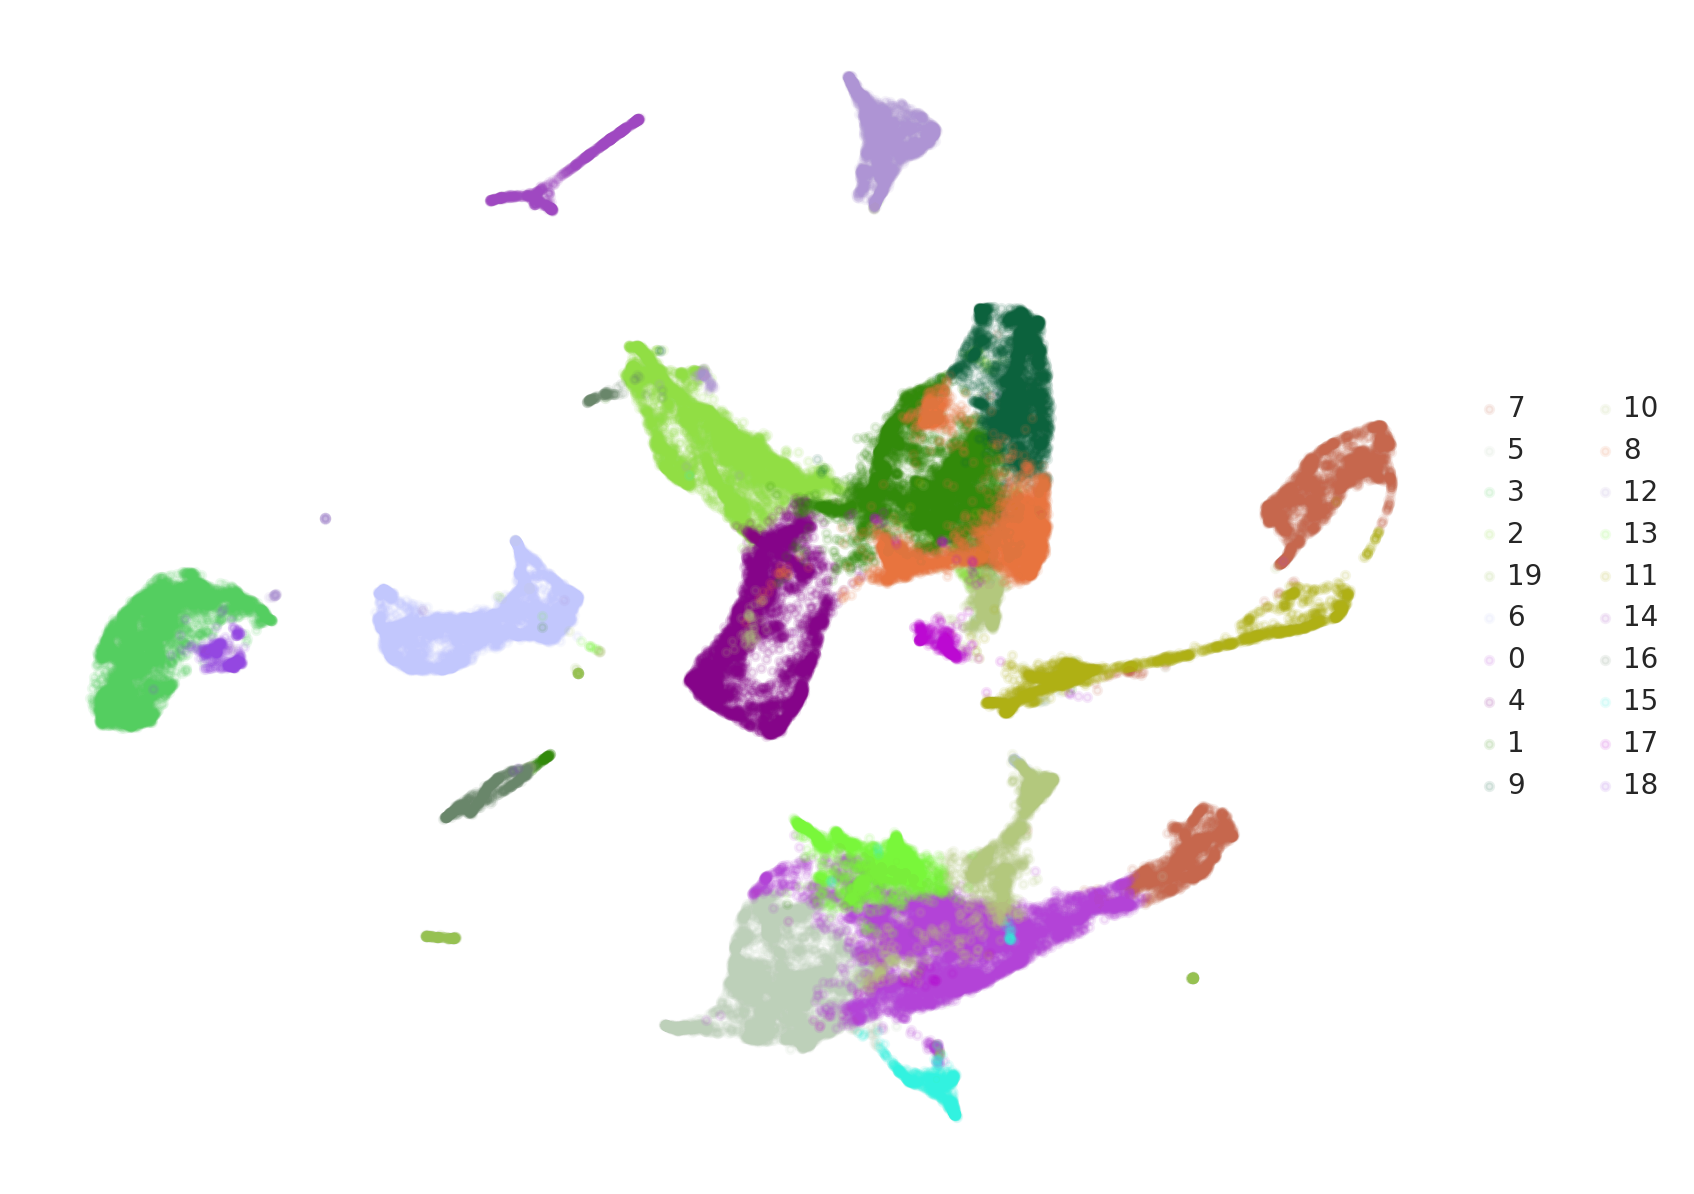

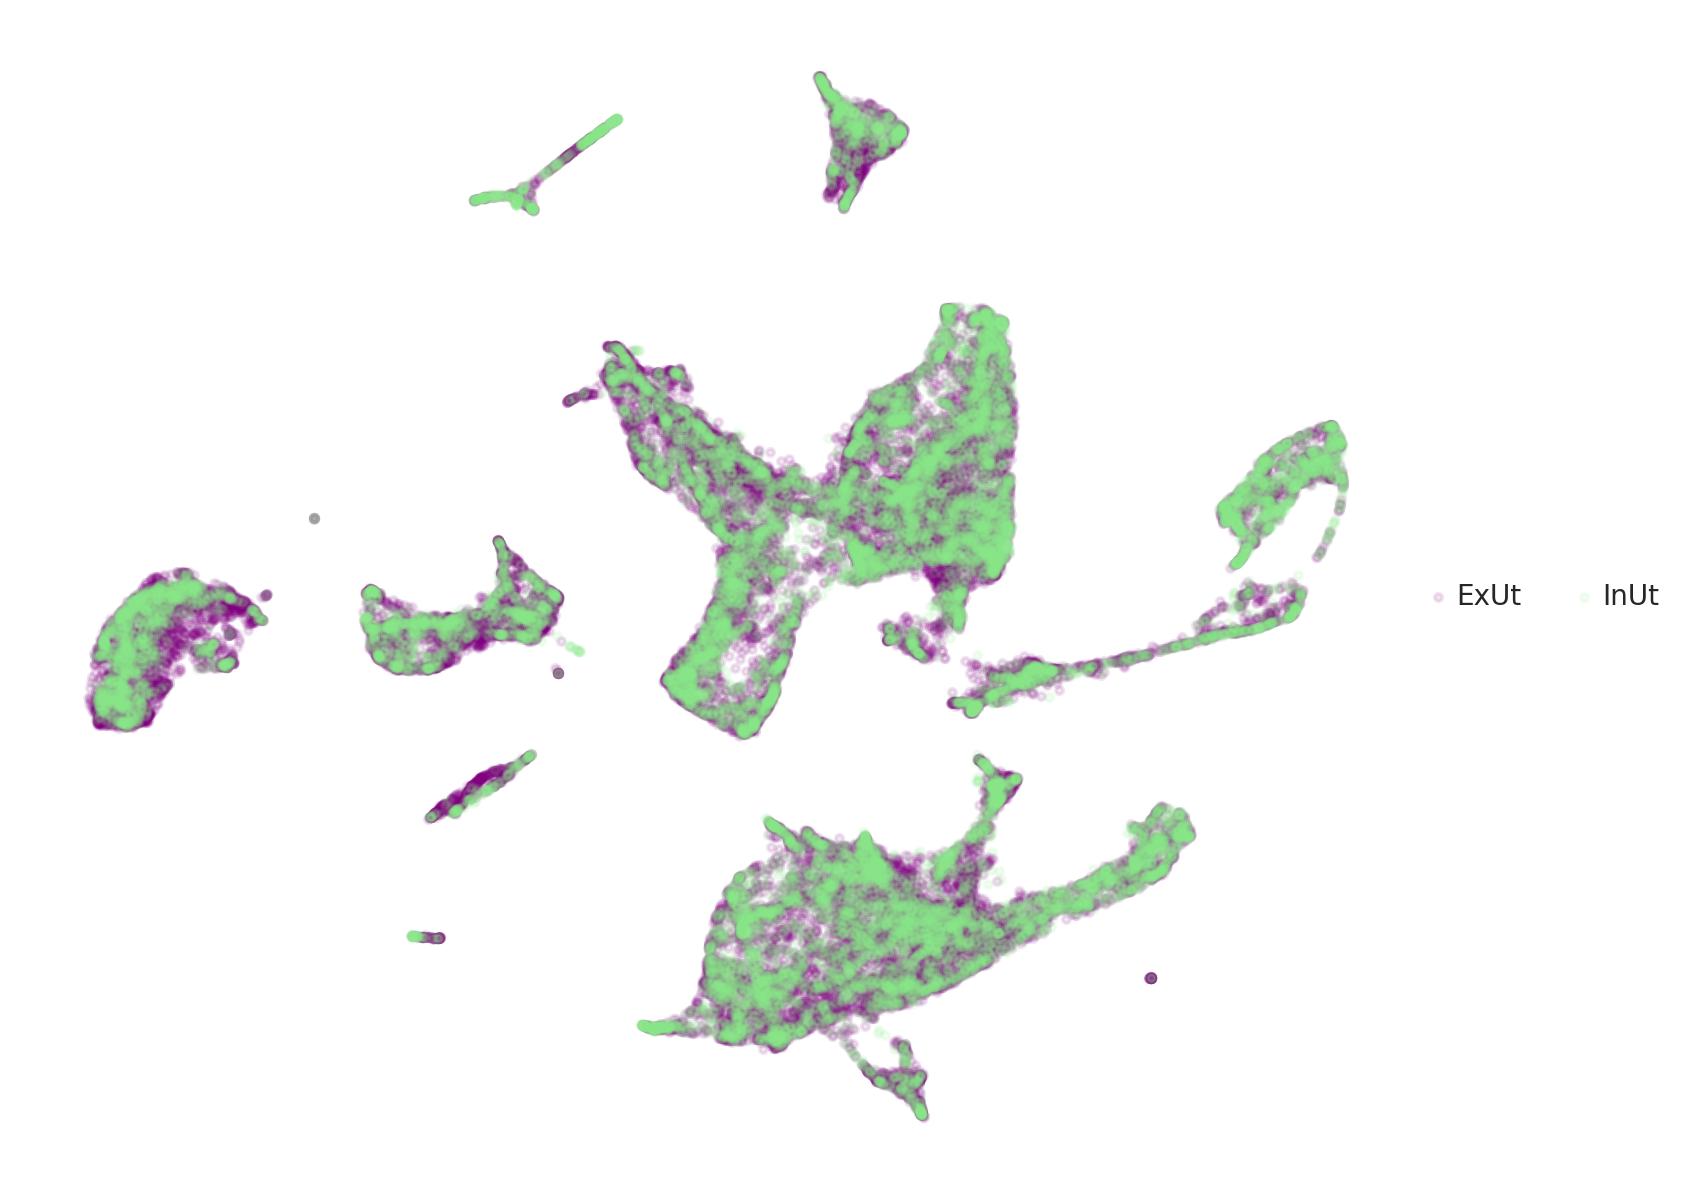

In [ ]:
#Seurat
vis.obj_plot_embed(pcaUMAP ,labs[0], fname = '2DNCA.pdf',colors=colors,alpha = 0.1 )
vis.obj_plot_embed(pcaUMAP, labs[1], fname = '2DNCA.pdf',colors=['purple','lightgreen'],alpha = 0.1)

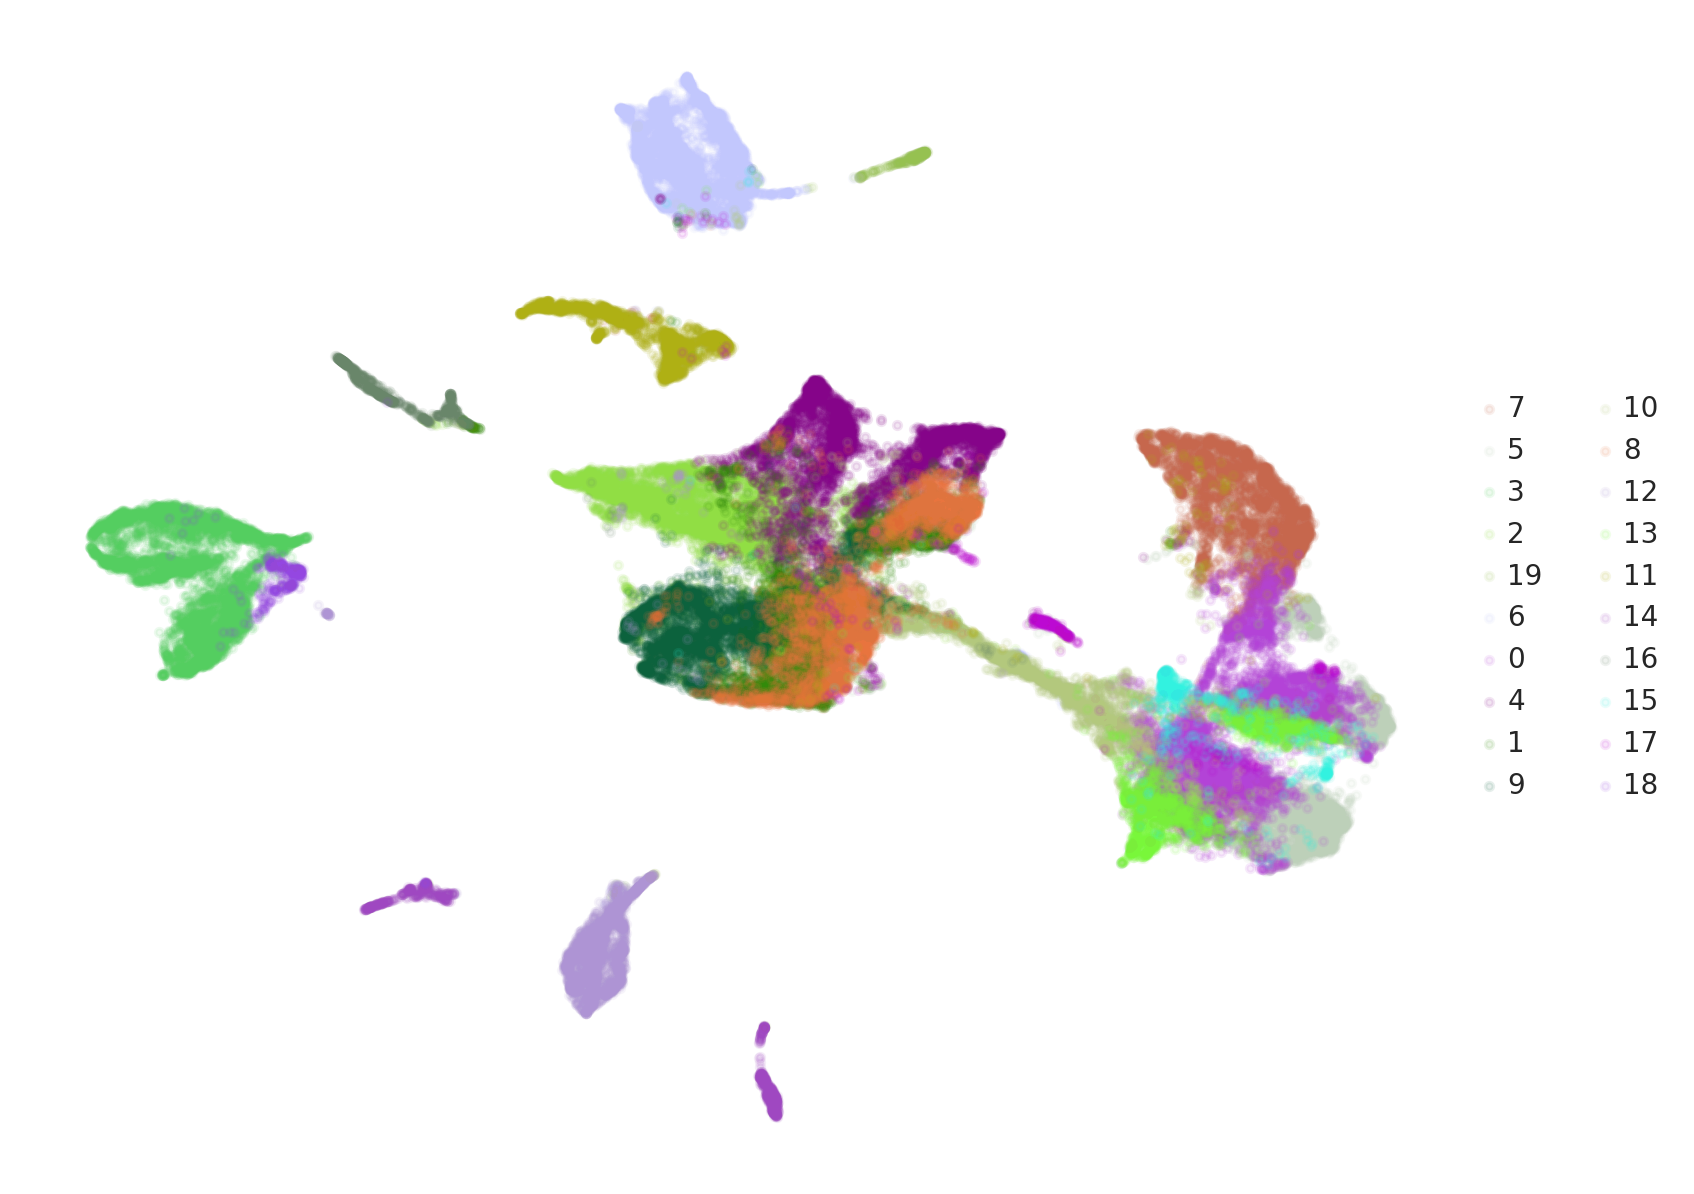

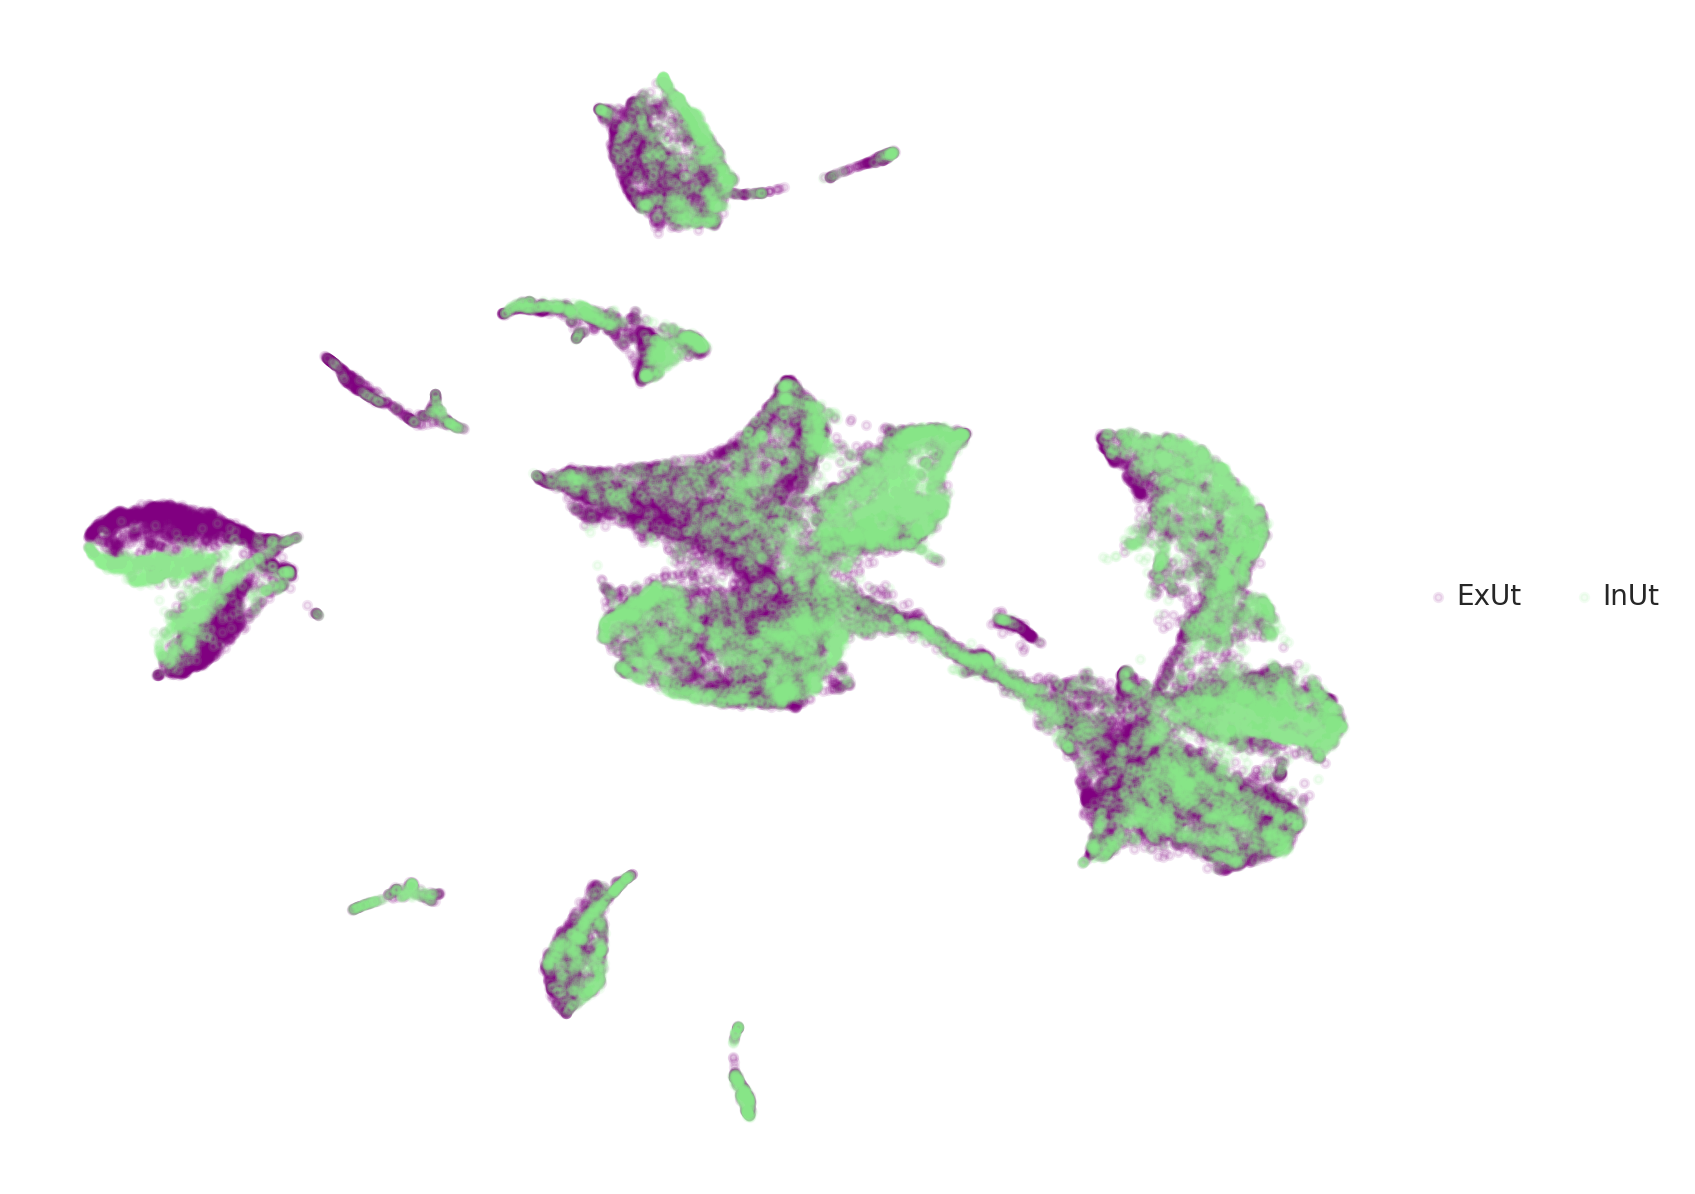

In [ ]:
#Seurat
vis.obj_plot_embed(pcalogUMAP ,labs[0], fname = '2DNCA.pdf',colors=colors ,alpha = 0.1)
vis.obj_plot_embed(pcalogUMAP, labs[1], fname = '2DNCA.pdf',colors=['purple','lightgreen'] ,alpha = 0.1)

#### Fraction of Nearest Neighbors (NNs) with the same label (in Integrated vs tSNE space). Comparing between log or scaled space and tSNE/UMAP space from 15D PCA projection.

In [ ]:
def frac_unique_neighbors(latent, cluster_label, metric = 1,neighbors = 30):
    """ Calculates the fraction of nearest neighbors from same cell type

    Returns:
    output: dictionary mapping each unique label in the category cluster_label
    to the fraction of neighbors in the same cluster, for each point in the cluster
    """

    cats = pd.Categorical(cluster_label)
    # Get nearest neighbors in each space
    n = neighbors
    neigh = NearestNeighbors(n_neighbors=n, p=metric)
    # Get transformed count matrices
    clusters = np.unique(cluster_label)
    unique_clusters = {}
    frac_neighbors = {}
    X_full  = latent
    neigh.fit(X_full)
    for c in clusters:
        X  = latent[cats == c, :]
        # Find n nearest neighbor cells (L1 distance)
        kNeigh = neigh.kneighbors(X)
        matNeigh = kNeigh[1]
        frac = np.zeros(matNeigh.shape[0])
        #How many of top n neighbors come from same cluster in the labeled data (out of n neighbors)
        unique_clusters[c] = np.unique([cats[matNeigh[i]] for i in range(0, len(frac))])
        frac_neighbors[c] = [cats[matNeigh[i]].value_counts()[c]/n for i in range(0,len(frac))]
    return frac_neighbors, unique_clusters

Next frac_unique_neighbors() steps will take a few hours on Colab

In [ ]:
ccaNeigh, ccaClus = frac_unique_neighbors(count_mat, labs[1]) #
#tsneNeigh, tsneClus = frac_unique_neighbors(pcaTSNE, labs[1]) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(pcaUMAP, labs[1]) #pcaUMAP2

#latents = [sum(list(ccaNeigh.values()), []),sum(list(tsneNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latents = [sum(list(ccaNeigh.values()), []),sum(list(umapNeigh.values()),[]) ]
latent = ['CCA','UMAP']

In [ ]:

#tsneNeigh, tsneClus = frac_unique_neighbors(pcalogTSNE, labs[1]) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(pcalogUMAP, labs[1]) #pcaUMAP2
logNeigh, logClus = frac_unique_neighbors(count_mat_orig, labs[1])

#latentsLog = [sum(list(tsneNeigh.values()),[]),sum(list(umapNeigh.values()),[]),sum(list(logNeigh.values()),[]) ]
latentsLog = [sum(list(logNeigh.values()),[]) ,sum(list(umapNeigh.values()),[])]
latentLog = ['Log','UMAP']

In [ ]:
#Make dataframe

ccaDF = pd.DataFrame()
ccaDF['Fraction'] = latents[0] + latents[1]
ccaDF['Embed'] = ['Variance Stabilized/Scaled Ambient']*len(latents[0]) + ['15D PCA UMAP']*len(latents[1])
ccaDF.head()

Fraction                               Embed
0  0.200000  Variance Stabilized/Scaled Ambient
1  0.066667  Variance Stabilized/Scaled Ambient
2  0.200000  Variance Stabilized/Scaled Ambient
3  0.133333  Variance Stabilized/Scaled Ambient
4  0.166667  Variance Stabilized/Scaled Ambient

In [ ]:
print(statistics.mode(ccaDF['Fraction'][ccaDF['Embed'].isin(['Variance Stabilized/Scaled Ambient'])]))
print(statistics.mode(ccaDF['Fraction'][ccaDF['Embed'].isin(['15D PCA UMAP'])]))


1.0
0.5333333333333333


<Figure size 1250x625 with 0 Axes>

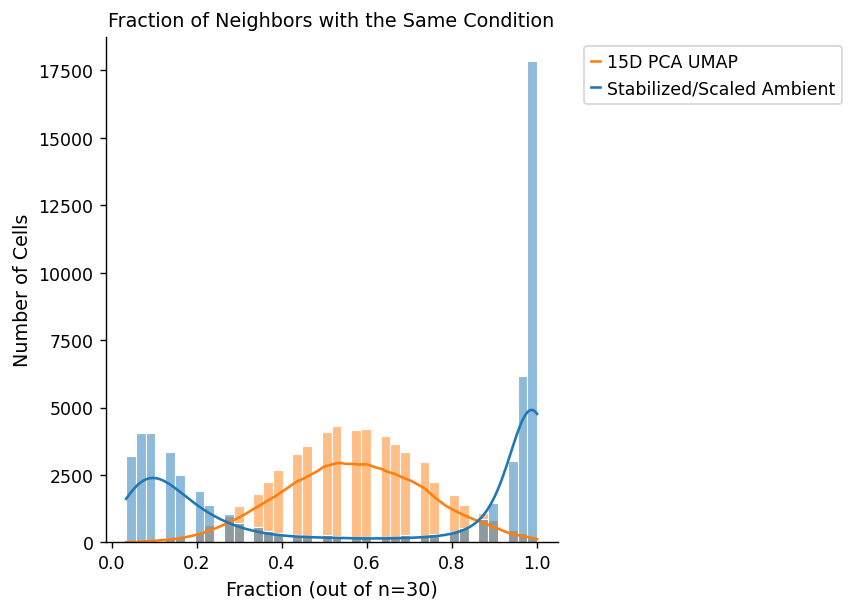

In [ ]:
plt.figure(figsize=(10,5))


g=sns.displot(data=ccaDF, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white")

plt.legend(['15D PCA UMAP','Stabilized/Scaled Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

In [ ]:
#Make dataframe

ccaDFlog = pd.DataFrame()
ccaDFlog['Fraction'] = latentsLog[0] + latentsLog[1]
ccaDFlog['Embed'] = ['Log-Normalized Ambient']*len(latentsLog[0]) + ['15D PCA UMAP']*len(latentsLog[1])
ccaDFlog.head()

Fraction                   Embed
0  0.466667  Log-Normalized Ambient
1  0.233333  Log-Normalized Ambient
2  0.466667  Log-Normalized Ambient
3  0.966667  Log-Normalized Ambient
4  0.966667  Log-Normalized Ambient

In [ ]:
print(statistics.mode(ccaDFlog['Fraction'][ccaDFlog['Embed'].isin(['Log-Normalized Ambient'])]))
print(statistics.mode(ccaDFlog['Fraction'][ccaDFlog['Embed'].isin(['15D PCA UMAP'])]))

0.5333333333333333
1.0


<Figure size 1250x625 with 0 Axes>

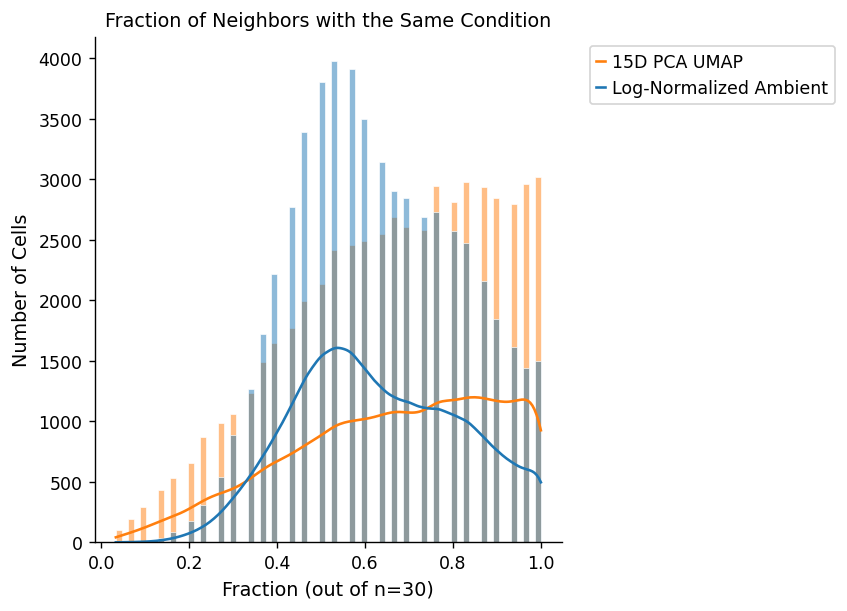

In [ ]:
#Test with log-normalized data only


plt.figure(figsize=(10,5))


g=sns.displot(data=ccaDFlog, x="Fraction", kde=True, hue='Embed',legend=False,edgecolor="white")

plt.legend([ '15D PCA UMAP','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()



Make plots for 2D uncoupled embedding distributions (log normalized only)

In [ ]:
# umap2_scale umap2_orig
logNeigh, logClus = frac_unique_neighbors(count_mat_orig, labs[1])
pcaNeigh, pcaClus = frac_unique_neighbors(pca2_orig, labs[1]) #
#tsneNeigh, tsneClus = frac_unique_neighbors(pcaTSNE, labs[1]) #pcaTSNE2
umapNeigh, umapClus = frac_unique_neighbors(umap2_orig, labs[1]) #pcaUMAP2

#latents = [sum(list(ccaNeigh.values()), []),sum(list(tsneNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latents = [sum(list(logNeigh.values()), []),sum(list(pcaNeigh.values()), []),sum(list(umapNeigh.values()),[]) ]
latent = ['Log-Normalized Ambient','PCA 2D','UMAP 2D']

In [ ]:
#Make dataframe

ccaDF = pd.DataFrame()
ccaDF['Fraction'] = latents[0] + latents[1] + latents[2]
ccaDF['Embed'] = ['Log-Normalized Ambient']*len(latents[0])+['PCA 2D']*len(latents[1]) + ['UMAP 2D']*len(latents[2])
ccaDF.head()

Fraction                   Embed
0  0.466667  Log-Normalized Ambient
1  0.233333  Log-Normalized Ambient
2  0.466667  Log-Normalized Ambient
3  0.966667  Log-Normalized Ambient
4  0.966667  Log-Normalized Ambient

In [ ]:
print(statistics.mode(ccaDF['Fraction'][ccaDF['Embed'].isin(['PCA 2D'])]))
print(statistics.mode(ccaDF['Fraction'][ccaDF['Embed'].isin(['UMAP 2D'])]))
print(statistics.mode(ccaDF['Fraction'][ccaDF['Embed'].isin(['Log-Normalized Ambient'])]))


0.6
1.0
0.5333333333333333


<Figure size 1250x625 with 0 Axes>

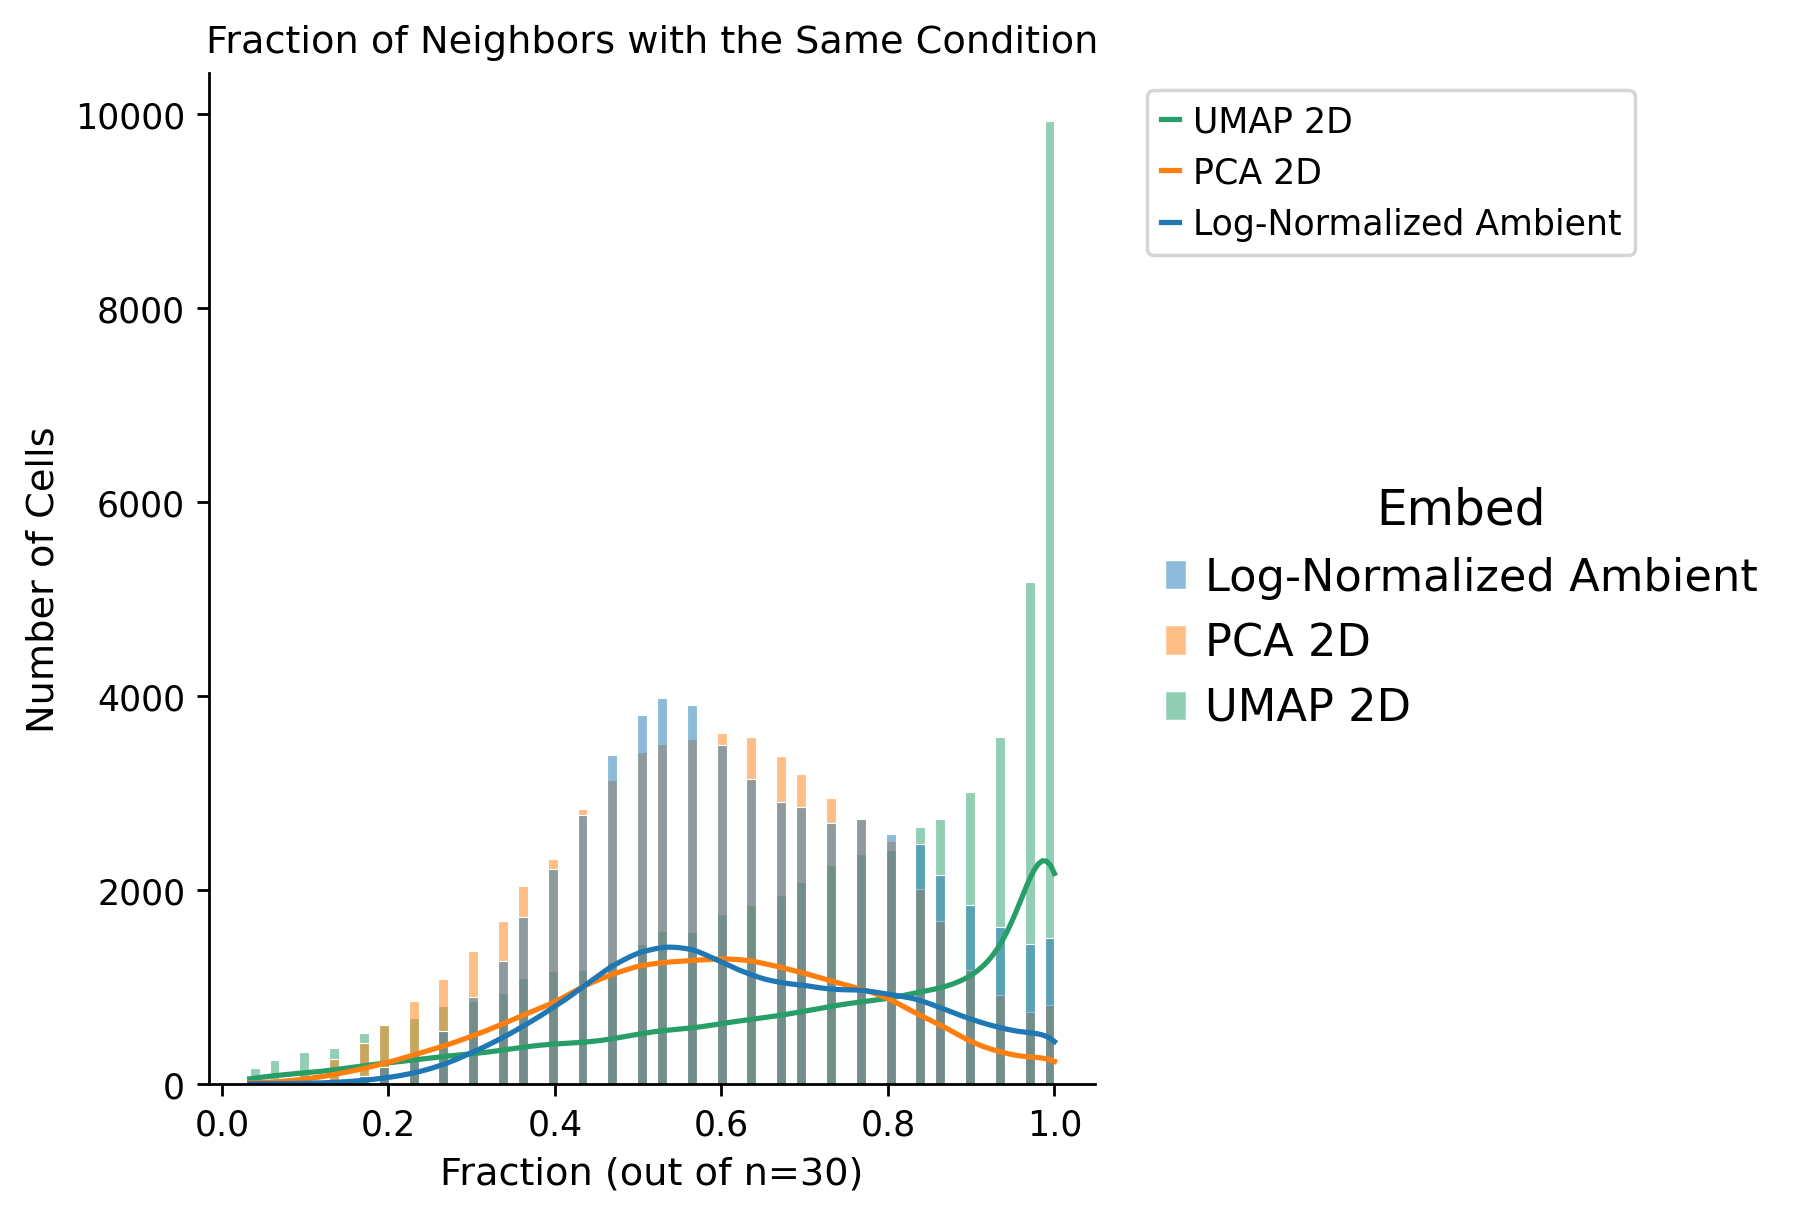

In [ ]:
plt.figure(figsize=(10,5))


g=sns.displot(data=ccaDF, x="Fraction", kde=True, hue='Embed',edgecolor="white") #legend=False

plt.legend(['UMAP 2D','PCA 2D','Log-Normalized Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})
plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()

Make plots for 2D uncoupled embedding distributions (variance stabilized and scaled)

In [ ]:
# umap2_scale umap2_orig
ccaNeigh, ccaClus = frac_unique_neighbors(count_mat, labs[1])
pcaNeighSc, pcaClusSc = frac_unique_neighbors(pca2_scale, labs[1]) #
#tsneNeigh, tsneClus = frac_unique_neighbors(pcaTSNE, labs[1]) #pcaTSNE2
umapNeighSc, umapClusSc = frac_unique_neighbors(umap2_scale, labs[1]) #pcaUMAP2

#latents = [sum(list(ccaNeigh.values()), []),sum(list(tsneNeigh.values()),[]),sum(list(umapNeigh.values()),[]) ]
latentsSc = [sum(list(ccaNeigh.values()), []),sum(list(pcaNeighSc.values()), []),sum(list(umapNeighSc.values()),[]) ]
latentSc = ['Variance Stabilized/Scaled Ambient','PCA 2D','UMAP 2D']

In [ ]:
#Make dataframe

ccaDFSc = pd.DataFrame()
ccaDFSc['Fraction'] = latentsSc[0] + latentsSc[1] + latentsSc[2]
ccaDFSc['Embed'] = ['Variance Stabilized/Scaled Ambient']*len(latentsSc[0]) + ['PCA 2D']*len(latentsSc[1]) + ['UMAP 2D']*len(latentsSc[2])
ccaDFSc.head()

Fraction                               Embed
0  0.200000  Variance Stabilized/Scaled Ambient
1  0.066667  Variance Stabilized/Scaled Ambient
2  0.200000  Variance Stabilized/Scaled Ambient
3  0.133333  Variance Stabilized/Scaled Ambient
4  0.166667  Variance Stabilized/Scaled Ambient

In [ ]:
print(statistics.mode(ccaDFSc['Fraction'][ccaDFSc['Embed'].isin(['PCA 2D'])]))
print(statistics.mode(ccaDFSc['Fraction'][ccaDFSc['Embed'].isin(['UMAP 2D'])]))
print(statistics.mode(ccaDFSc['Fraction'][ccaDFSc['Embed'].isin(['Variance Stabilized/Scaled Ambient'])]))

0.5666666666666667
0.6333333333333333
1.0


<Figure size 1250x625 with 0 Axes>

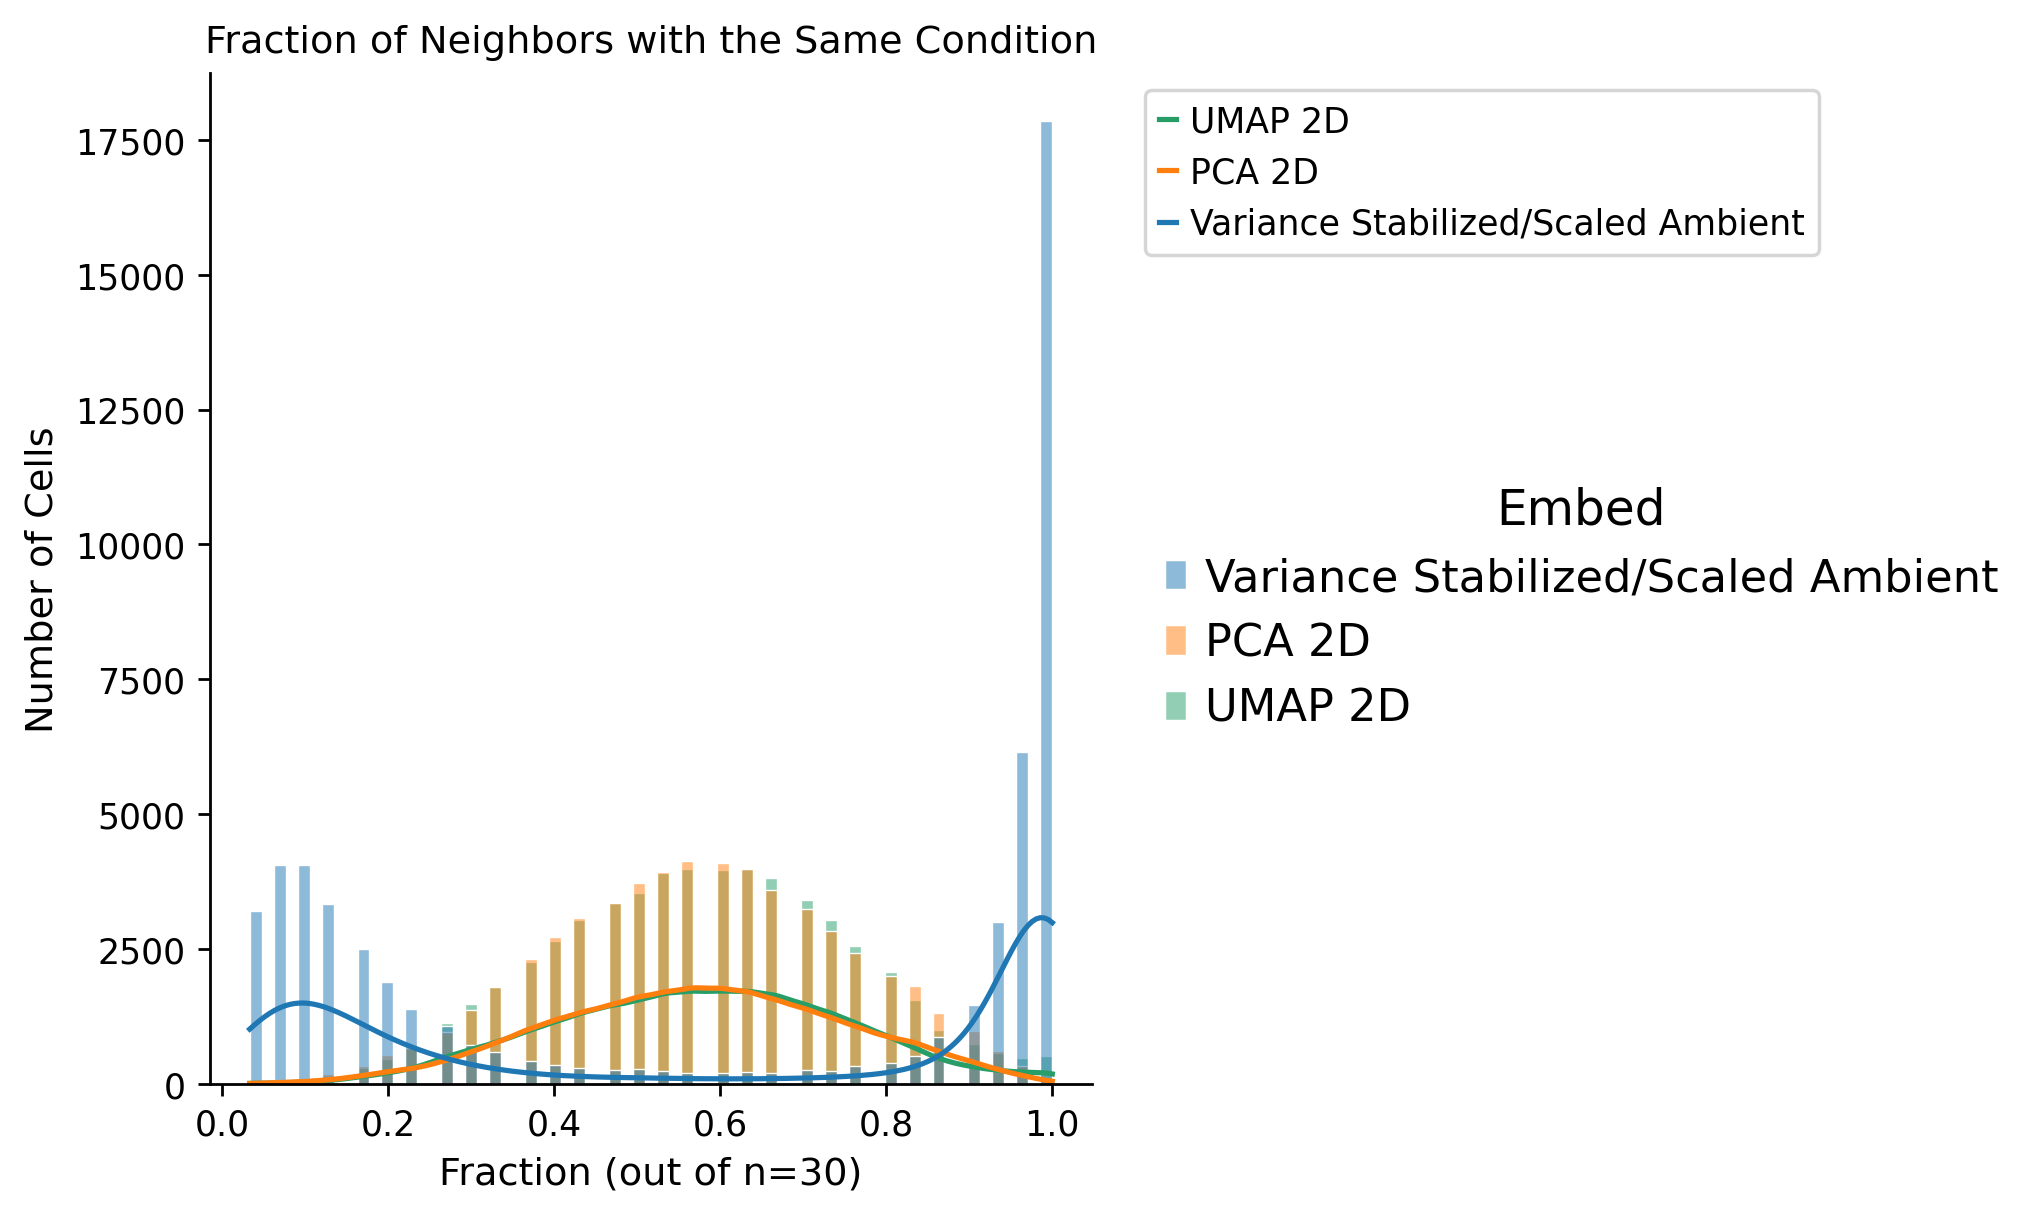

In [ ]:
plt.figure(figsize=(10,5))


g=sns.displot(data=ccaDFSc, x="Fraction", kde=True, hue='Embed',edgecolor="white") #legend=False

plt.legend(['UMAP 2D','PCA 2D','Variance Stabilized/Scaled Ambient'],bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})

plt.title('Fraction of Neighbors with the Same Condition',fontsize=11)

plt.xlabel("Fraction (out of n=30)",fontsize=11)
plt.ylabel("Number of Cells",fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()
plt.show()